In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("../../assets/huggingface_with_fairness.csv")

In [5]:
features = ['performance_score', 'co2_eq_emissions']
df_cluster = df[features].dropna()

# 2. Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)
df_scaled = pd.DataFrame(df_scaled, columns=features)

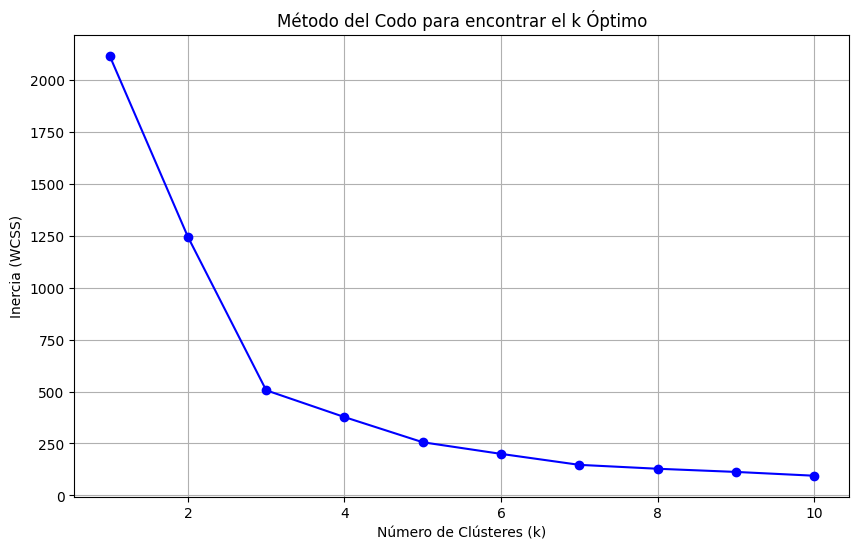

In [6]:
inertia = []
K = range(1, 11) # Probaremos con k desde 1 hasta 10

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42) # n_init=10 es para robustez
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el M√©todo del Codo
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('N√∫mero de Cl√∫steres (k)')
plt.ylabel('Inercia (WCSS)')
plt.title('M√©todo del Codo para encontrar el k √ìptimo')
plt.grid(True)
plt.show()

In [7]:
optimal_k = 3

# Ejecutar K-Means con el n√∫mero √≥ptimo de cl√∫steres
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# A√±adir la asignaci√≥n de cl√∫steres al DataFrame original
df_cluster['kmeans_cluster'] = clusters

print(f"\nSe han asignado los datos a {optimal_k} cl√∫steres.")
print(df_cluster.head())


Se han asignado los datos a 3 cl√∫steres.
   performance_score  co2_eq_emissions  kmeans_cluster
0           0.513276        133.021988               1
1           0.602463        126.344463               1
2           0.961060          7.989145               0
3           0.929787         55.101963               0
4           0.778492        123.880231               0



--- Resumen de Caracter√≠sticas por Cl√∫ster (K-Means) ---
                performance_score  co2_eq_emissions
kmeans_cluster                                     
0                        0.884827         16.815551
2                        0.409739       2792.059033
1                        0.364463         90.652209


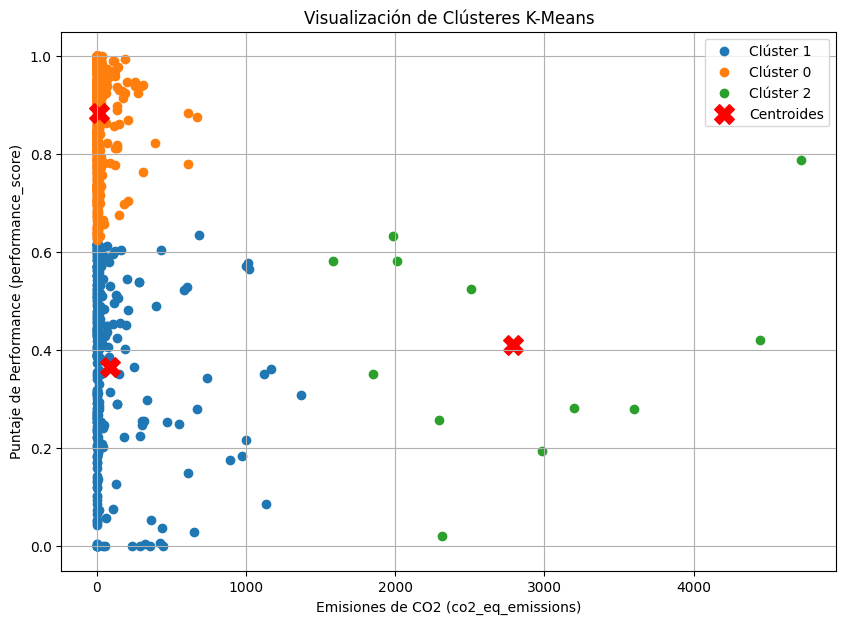

In [8]:
# Agrupar por cl√∫ster y calcular la media de las caracter√≠sticas
kmeans_summary = df_cluster.groupby('kmeans_cluster')[features].mean().sort_values(by='performance_score', ascending=False)

print("\n--- Resumen de Caracter√≠sticas por Cl√∫ster (K-Means) ---")
print(kmeans_summary)

# Visualizar los cl√∫steres
plt.figure(figsize=(10, 7))
# Usamos df_scaled para obtener las coordenadas de los centroides
centers_scaled = kmeans.cluster_centers_ 
# Revertimos la estandarizaci√≥n para graficar los centroides en la escala original
centers = scaler.inverse_transform(centers_scaled)

# Graficar los puntos de cada cl√∫ster
for cluster_id in df_cluster['kmeans_cluster'].unique():
    subset = df_cluster[df_cluster['kmeans_cluster'] == cluster_id]
    plt.scatter(subset['co2_eq_emissions'], subset['performance_score'], label=f'Cl√∫ster {cluster_id}')

# Graficar los centroides
plt.scatter(centers[:, 1], centers[:, 0], s=200, c='red', marker='X', label='Centroides')

plt.title('Visualizaci√≥n de Cl√∫steres K-Means')
plt.xlabel('Emisiones de CO2 (co2_eq_emissions)')
plt.ylabel('Puntaje de Performance (performance_score)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

## Interpretaci√≥n de Cada Cl√∫ster
#üèÜ Cl√∫ster 0 (Naranja): Los Modelos Ideales
#Posici√≥n: Este grupo se encuentra en la esquina superior izquierda.

#Significado: Tiene un alto puntaje de performance (eje Y) y muy bajas emisiones de CO2 (eje X).

#Conclusi√≥n: Estos son tus mejores modelos. Son altamente eficientes, logrando los mejores resultados con el m√≠nimo impacto ambiental. Deber√≠as estudiar qu√© caracter√≠sticas tienen en com√∫n estos modelos para replicar su √©xito.

#‚úÖ Cl√∫ster 1 (Azul): Los de Bajo Impacto pero Rendimiento Moderado
#Posici√≥n: Se agrupa en la parte inferior izquierda.

#Significado: Tiene un performance de bajo a moderado pero tambi√©n mantiene bajas emisiones de CO2.

#Conclusi√≥n: Este es el grupo m√°s numeroso. No son los de mejor rendimiento, pero al menos son ecol√≥gicos. Representan un "est√°ndar" o una l√≠nea base. El objetivo podr√≠a ser encontrar maneras de mejorar su performance sin aumentar significativamente sus emisiones.

#‚ö†Ô∏è Cl√∫ster 2 (Verde): Los de Alto Costo Ambiental
#Posici√≥n: Se extiende hacia la derecha del gr√°fico.

#Significado: Tiene un performance moderado, pero a cambio de emisiones de CO2 extremadamente altas.

#Conclusi√≥n: Estos son los modelos ineficientes. El costo ambiental que pagan es desproporcionado para el rendimiento que ofrecen. Generalmente, estos son los modelos que deber√≠as evitar, optimizar para reducir su huella de carbono, o usar solo si su performance es absolutamente cr√≠tico y no hay alternativa.

## En Resumen
#Tu an√°lisis de K-Means ha segmentado exitosamente tus modelos en tres categor√≠as claras y √∫tiles:

#Ideales (Naranja): Alto rendimiento, bajo costo. El objetivo a seguir.

#Base (Azul): Rendimiento modesto, bajo costo. Un punto de partida para mejorar.

#Ineficientes (Verde): Rendimiento modesto, alto costo. Modelos a evitar o redise√±ar.

In [10]:
cluster_map = {
    0: 'Ideal', 
    2: 'Ineficiente', 
    1: 'Costoso'
}
df_cluster['categoria'] = df_cluster['kmeans_cluster'].map(cluster_map)

# 2. Definir las variables predictoras (X) y la variable objetivo (y)
# Empezaremos con las dos variables m√°s importantes para una f√°cil visualizaci√≥n.
features = ['performance_score', 'co2_eq_emissions']
X = df_cluster[features]
y = df_cluster['categoria']

# 3. Eliminar filas donde la categor√≠a pueda ser nula (si alg√∫n mapeo fall√≥)
X = X[y.notna()]
y = y.dropna()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, # Para que los resultados sean reproducibles
    stratify=y # Asegura que la proporci√≥n de clases sea la misma en ambos sets
)

In [14]:
# Inicializar el clasificador de √Årbol de Decisi√≥n
# max_depth limita la profundidad del √°rbol para hacerlo m√°s interpretable
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

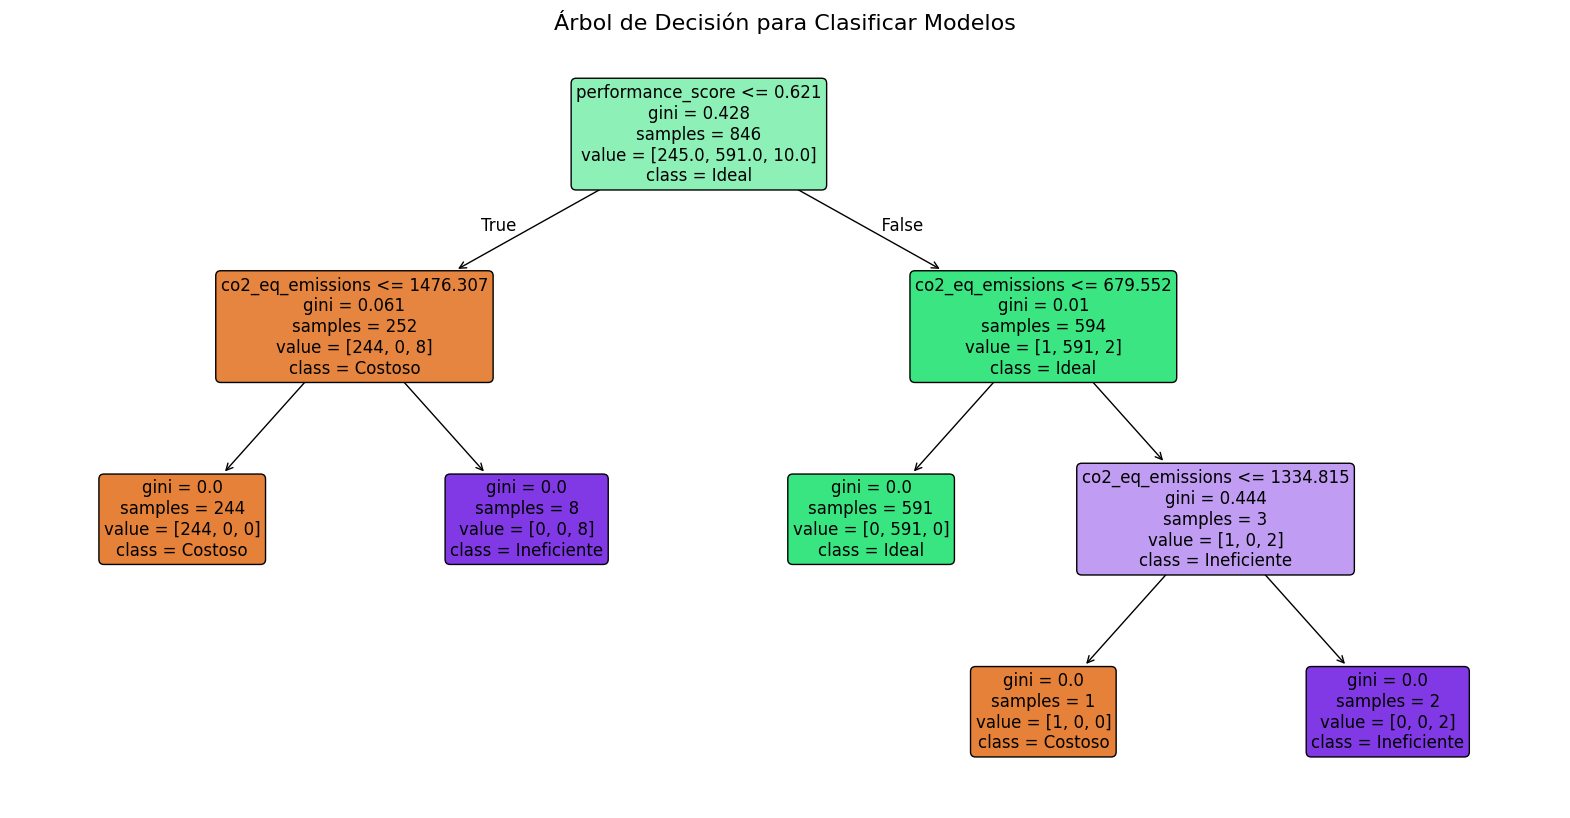

In [15]:
plt.figure(figsize=(20, 10))
plot_tree(
    tree_model, 
    feature_names=features, 
    class_names=tree_model.classes_, # Nombres de las categor√≠as
    filled=True, # Colorea los nodos seg√∫n la clase mayoritaria
    rounded=True, # Nodos con bordes redondeados
    fontsize=12
)
plt.title("√Årbol de Decisi√≥n para Clasificar Modelos", fontsize=16)
plt.show()

In [16]:
# Realizar predicciones en el conjunto de prueba
y_pred = tree_model.predict(X_test)

# Calcular la precisi√≥n
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisi√≥n del modelo: {accuracy:.2%}\n")

# Mostrar un reporte de clasificaci√≥n detallado
print("Reporte de Clasificaci√≥n:")
print(classification_report(y_test, y_pred))

Precisi√≥n del modelo: 100.00%

Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

     Costoso       1.00      1.00      1.00        62
       Ideal       1.00      1.00      1.00       148
 Ineficiente       1.00      1.00      1.00         2

    accuracy                           1.00       212
   macro avg       1.00      1.00      1.00       212
weighted avg       1.00      1.00      1.00       212

